# 01_data_build_colored
- Author: 정재훈
- Date: 2025-11-10
- Goal: Colored MNIST 생성(색/배경 옵션)
- Input: 
- Output: 
- Metrics: acc@val, loss@train
- Repro: seed=42, device=auto, config=../configs/


In [12]:
# ============================================================
# 01_preprocessing_colored_mnist.ipynb
#
# Colored MNIST Preprocessing + EDA + Augmentation (Stable)
# - Uses ML_Project.zip resources:
#     data/raw/mnist/mnist_train.npz
#     data/raw/fonts/MaruBuri-*.ttf (optional)
# - Output:
#     data/processed/colored_mnist/colored_mnist.npz
# - Designed for classical ML only (KNN, SVM, DT, RF, LogReg)
# ============================================================

import os
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw, ImageFont
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:

# -----------------------------
# [Cell 1] Matplotlib (English only)
# -----------------------------
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["axes.unicode_minus"] = False
print("Matplotlib font:", plt.rcParams["font.family"])

Matplotlib font: ['DejaVu Sans']


In [16]:
# -----------------------------
# [Cell 2] Paths & config
# -----------------------------
BASE_DIR = os.getcwd()  # run from repo root
RAW_MNIST_PATH = os.path.join(BASE_DIR, "data", "raw", "mnist", "mnist_train.npz")
FONTS_DIR = os.path.join(BASE_DIR, "data", "raw", "fonts")
PROCESSED_DIR = os.path.join(BASE_DIR, "data", "processed", "colored_mnist")
os.makedirs(PROCESSED_DIR, exist_ok=True)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print("[INFO] BASE_DIR      :", BASE_DIR)
print("[INFO] RAW_MNIST_PATH:", RAW_MNIST_PATH)
print("[INFO] FONTS_DIR     :", FONTS_DIR)
print("[INFO] PROCESSED_DIR :", PROCESSED_DIR)

[INFO] BASE_DIR      : /Users/jaehun_jung/colored-mnist-classification/notebooks
[INFO] RAW_MNIST_PATH: /Users/jaehun_jung/colored-mnist-classification/notebooks/data/raw/mnist/mnist_train.npz
[INFO] FONTS_DIR     : /Users/jaehun_jung/colored-mnist-classification/notebooks/data/raw/fonts
[INFO] PROCESSED_DIR : /Users/jaehun_jung/colored-mnist-classification/notebooks/data/processed/colored_mnist


In [17]:
# -----------------------------
# [Cell 3] Load MNIST
# -----------------------------
if not os.path.exists(RAW_MNIST_PATH):
    raise FileNotFoundError(
        f"{RAW_MNIST_PATH} not found.\n"
        "Place mnist_train.npz under data/raw/mnist/."
    )

mnist = np.load(RAW_MNIST_PATH)
print("[INFO] mnist_train.npz keys:", list(mnist.keys()))

if "train_images" in mnist and "train_labels" in mnist:
    X_gray = mnist["train_images"].astype(np.float32) / 255.0  # (N,28,28)
    y_digit = mnist["train_labels"].astype(np.int64)
else:
    raise KeyError(
        "Expected keys 'train_images' and 'train_labels' in mnist_train.npz."
    )

print(f"[OK] Loaded MNIST: X_gray={X_gray.shape}, y_digit={y_digit.shape}")

[INFO] mnist_train.npz keys: ['train_images', 'train_labels']
[OK] Loaded MNIST: X_gray=(60000, 28, 28), y_digit=(60000,)


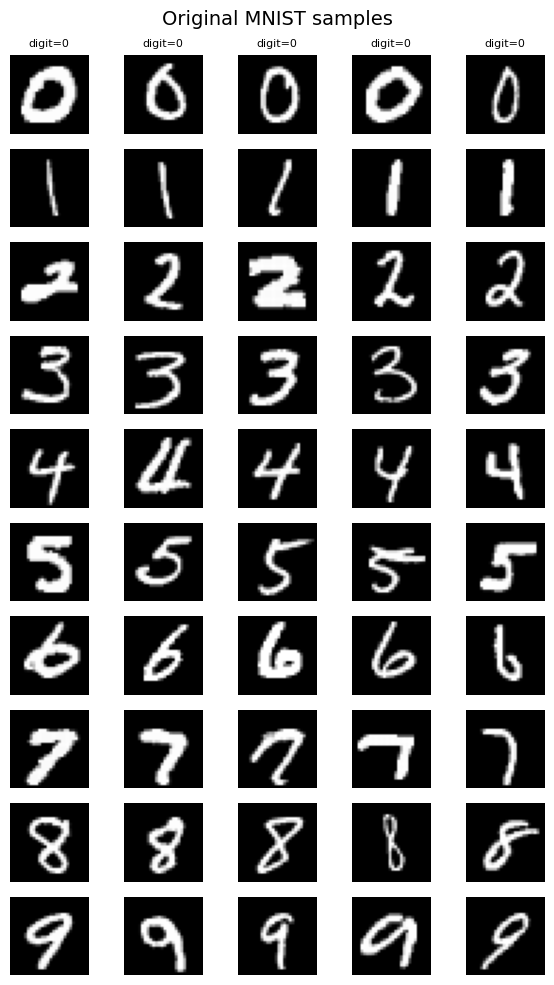

In [18]:
# -----------------------------
# [Cell 4] EDA-1: show original digits
# -----------------------------
def show_original_mnist_samples(X, y, n_per_digit=5):
    digits = np.arange(10)
    plt.figure(figsize=(n_per_digit * 1.2, 10))
    idx = 1
    for d in digits:
        idxs = np.where(y == d)[0]
        n_show = min(n_per_digit, len(idxs))
        chosen = np.random.choice(idxs, size=n_show, replace=False)
        for ci in chosen:
            plt.subplot(10, n_per_digit, idx)
            plt.imshow(X[ci], cmap="gray")
            plt.axis("off")
            if idx <= n_per_digit:
                plt.title(f"digit={d}", fontsize=8)
            idx += 1
    plt.suptitle("Original MNIST samples", fontsize=14)
    plt.tight_layout()
    plt.show()

show_original_mnist_samples(X_gray, y_digit, n_per_digit=5)

In [19]:
# -----------------------------
# [Cell 5] Load fonts (optional)
# -----------------------------
font_paths = []
if os.path.isdir(FONTS_DIR):
    for fname in sorted(os.listdir(FONTS_DIR)):
        if fname.lower().endswith(".ttf"):
            font_paths.append(os.path.join(FONTS_DIR, fname))

if font_paths:
    print("[OK] Found fonts:")
    for p in font_paths:
        print("   -", os.path.basename(p))
else:
    print("[WARN] No .ttf fonts found. Font-based data will be skipped.")

[OK] Found fonts:
   - MaruBuri-Bold.ttf
   - MaruBuri-ExtraLight.ttf
   - MaruBuri-Light.ttf
   - MaruBuri-Regular.ttf
   - MaruBuri-SemiBold.ttf


In [20]:
# -----------------------------
# [Cell 6] Color palette & utils
# -----------------------------
RAINBOW_COLORS = [
    (255,   0,   0),  # 0 RED
    (255, 127,   0),  # 1 ORANGE
    (255, 255,   0),  # 2 YELLOW
    (  0, 255,   0),  # 3 GREEN
    (  0,   0, 255),  # 4 BLUE
    ( 75,   0, 130),  # 5 INDIGO
    (148,   0, 211),  # 6 VIOLET
]
COLOR_NAMES = ["RED", "ORANGE", "YELLOW", "GREEN", "BLUE", "INDIGO", "VIOLET"]
NUM_COLORS = len(RAINBOW_COLORS)

def sample_fg_bg_indices():
    """Sample different fg/bg color indices."""
    fg = np.random.randint(0, NUM_COLORS)
    bg = np.random.randint(0, NUM_COLORS)
    while bg == fg:
        bg = np.random.randint(0, NUM_COLORS)
    return fg, bg

def gray_to_colored_feature(gray_img, fg_idx, bg_idx, threshold=0.25):
    """
    Grayscale (28x28, [0,1]) -> Colored (28*28*3, [0,1]).
    Foreground: gray > threshold.
    """
    fg_color = np.array(RAINBOW_COLORS[fg_idx], dtype=np.float32) / 255.0
    bg_color = np.array(RAINBOW_COLORS[bg_idx], dtype=np.float32) / 255.0

    mask = (gray_img > threshold).astype(np.float32)
    mask_3 = mask[..., None]  # (28,28,1)

    colored = np.ones((28, 28, 3), dtype=np.float32) * bg_color
    colored = mask_3 * fg_color + (1.0 - mask_3) * colored
    return colored.reshape(-1).astype(np.float32)

def center_digit(gray_img, thr=0.98):
    """
    Center-align a rendered digit using its foreground bbox.
    """
    mask = gray_img < thr  # darker than background
    coords = np.argwhere(mask)
    if coords.size == 0:
        return gray_img
    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0) + 1
    cropped = gray_img[y_min:y_max, x_min:x_max]
    h, w = cropped.shape

    canvas = np.ones((28, 28), dtype=np.float32)
    y_off = (28 - h) // 2
    x_off = (28 - w) // 2
    canvas[y_off:y_off+h, x_off:x_off+w] = cropped
    return canvas

def render_digit_with_font_centered(digit, font_path, image_size=28):
    """
    Render digit with TTF font and center it.
    """
    img = Image.new("L", (image_size, image_size), color=255)
    draw = ImageDraw.Draw(img)
    text = str(digit)
    try:
        font = ImageFont.truetype(font_path, size=24)
    except Exception as e:
        print(f"[WARN] Font load failed: {font_path}, {e}")
        return None
    bbox = draw.textbbox((0, 0), text, font=font)
    tw, th = bbox[2]-bbox[0], bbox[3]-bbox[1]
    x = (image_size - tw)//2
    y = (image_size - th)//2 - 1
    draw.text((x, y), text, fill=0, font=font)
    arr = np.array(img).astype(np.float32) / 255.0
    return center_digit(arr, thr=0.98)

def augment_gray_image(gray_img,
                       max_rotation=15,
                       max_shift=2,
                       noise_std=0.05):
    """
    Augment grayscale digit:
    - small rotation
    - small translation
    - light Gaussian noise
    """
    img = Image.fromarray((gray_img * 255).astype(np.uint8))

    # rotation
    angle = np.random.uniform(-max_rotation, max_rotation)
    img = img.rotate(angle, fillcolor=255)

    # translation
    tx = np.random.uniform(-max_shift, max_shift)
    ty = np.random.uniform(-max_shift, max_shift)
    img = img.transform(
        img.size,
        Image.AFFINE,
        (1, 0, tx, 0, 1, ty),
        fillcolor=255,
    )

    arr = np.array(img).astype(np.float32) / 255.0

    if noise_std > 0:
        noise = np.random.normal(0.0, noise_std, size=arr.shape).astype(np.float32)
        arr = np.clip(arr + noise, 0.0, 1.0)

    return arr

print("[OK] Palette & utility functions ready.")

[OK] Palette & utility functions ready.


In [21]:
# -----------------------------
# [Cell 7] Base colored dataset
#   - main: one colored version per original (1:1 mapping)
#   - aug : extra augmented versions (추가 데이터)
# -----------------------------

print("[INFO] Generating base colored dataset...")

P_AUG_BASE = 0.30  # prob to add one augmented sample per original

base_main_features = []
base_main_digit = []
base_main_fg = []
base_main_bg = []

base_aug_features = []
base_aug_digit = []
base_aug_fg = []
base_aug_bg = []

for gray, d in zip(X_gray, y_digit):
    # main (aligned) sample
    fg_idx, bg_idx = sample_fg_bg_indices()
    feat = gray_to_colored_feature(gray, fg_idx, bg_idx)
    base_main_features.append(feat)
    base_main_digit.append(d)
    base_main_fg.append(fg_idx)
    base_main_bg.append(bg_idx)

    # optional augmented sample (goes to aug set)
    if np.random.rand() < P_AUG_BASE:
        aug_gray = augment_gray_image(gray)
        fg2, bg2 = sample_fg_bg_indices()
        feat2 = gray_to_colored_feature(aug_gray, fg2, bg2)
        base_aug_features.append(feat2)
        base_aug_digit.append(d)
        base_aug_fg.append(fg2)
        base_aug_bg.append(bg2)

base_main_features = np.stack(base_main_features, axis=0)
base_main_digit = np.array(base_main_digit, dtype=np.int64)
base_main_fg = np.array(base_main_fg, dtype=np.int64)
base_main_bg = np.array(base_main_bg, dtype=np.int64)

print(f"[OK] base_main_features: {base_main_features.shape}")

if base_aug_features:
    base_aug_features = np.stack(base_aug_features, axis=0)
    base_aug_digit = np.array(base_aug_digit, dtype=np.int64)
    base_aug_fg = np.array(base_aug_fg, dtype=np.int64)
    base_aug_bg = np.array(base_aug_bg, dtype=np.int64)
    print(f"[OK] base_aug_features: {base_aug_features.shape}")
else:
    base_aug_features = None
    print("[INFO] No base augment samples generated (check P_AUG_BASE).")

[INFO] Generating base colored dataset...
[OK] base_main_features: (60000, 2352)
[OK] base_aug_features: (17867, 2352)


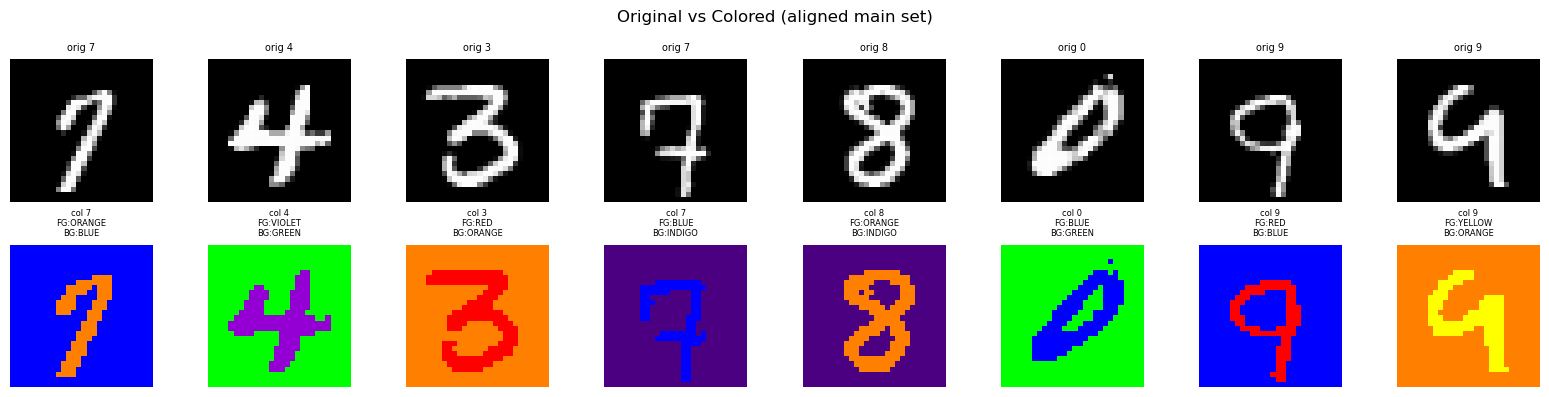

In [22]:
# -----------------------------
# [Cell 8] EDA-2: Original vs colored (aligned only)
#   - uses base_main_* so index 매칭 100% 보장
# -----------------------------
def show_gray_vs_colored_aligned(X_gray, y_digit,
                                 colored_main, fg_labels, bg_labels,
                                 n=8):
    n = min(n, X_gray.shape[0])
    idxs = np.random.choice(np.arange(X_gray.shape[0]), size=n, replace=False)
    plt.figure(figsize=(2 * n, 4))
    for i, idx in enumerate(idxs):
        gray = X_gray[idx]
        colored = colored_main[idx].reshape(28, 28, 3)
        d = y_digit[idx]
        fg = COLOR_NAMES[fg_labels[idx]]
        bg = COLOR_NAMES[bg_labels[idx]]

        plt.subplot(2, n, i + 1)
        plt.imshow(gray, cmap="gray")
        plt.axis("off")
        plt.title(f"orig {d}", fontsize=7)

        plt.subplot(2, n, n + i + 1)
        plt.imshow(colored)
        plt.axis("off")
        plt.title(f"col {d}\nFG:{fg}\nBG:{bg}", fontsize=6)

    plt.suptitle("Original vs Colored (aligned main set)", fontsize=12)
    plt.tight_layout()
    plt.show()

show_gray_vs_colored_aligned(
    X_gray, y_digit,
    base_main_features, base_main_fg, base_main_bg,
    n=8,
)

In [23]:
# -----------------------------
# [Cell 9] Font-based colored dataset (optional)
# -----------------------------
font_features = None
font_digit_labels = None
font_fg_labels = None
font_bg_labels = None

if font_paths:
    print("[INFO] Generating font-based colored dataset...")
    tmp_f, tmp_d, tmp_fg, tmp_bg = [], [], [], []
    SAMPLES_PER_DIGIT_PER_FONT = 120
    P_AUG_FONT = 0.5

    for d in range(10):
        for font_path in font_paths:
            for _ in range(SAMPLES_PER_DIGIT_PER_FONT):
                gray_font = render_digit_with_font_centered(d, font_path)
                if gray_font is None:
                    continue
                if np.random.rand() < P_AUG_FONT:
                    gray_use = augment_gray_image(gray_font)
                else:
                    gray_use = gray_font
                fg_idx, bg_idx = sample_fg_bg_indices()
                feat = gray_to_colored_feature(gray_use, fg_idx, bg_idx)

                tmp_f.append(feat)
                tmp_d.append(d)
                tmp_fg.append(fg_idx)
                tmp_bg.append(bg_idx)

    if tmp_f:
        font_features = np.stack(tmp_f, axis=0)
        font_digit_labels = np.array(tmp_d, dtype=np.int64)
        font_fg_labels = np.array(tmp_fg, dtype=np.int64)
        font_bg_labels = np.array(tmp_bg, dtype=np.int64)
        print(f"[OK] font_features: {font_features.shape}")
    else:
        print("[WARN] No valid font-based samples generated.")
else:
    print("[INFO] Skip font-based synthesis (no fonts).")

[INFO] Generating font-based colored dataset...
[OK] font_features: (6000, 2352)


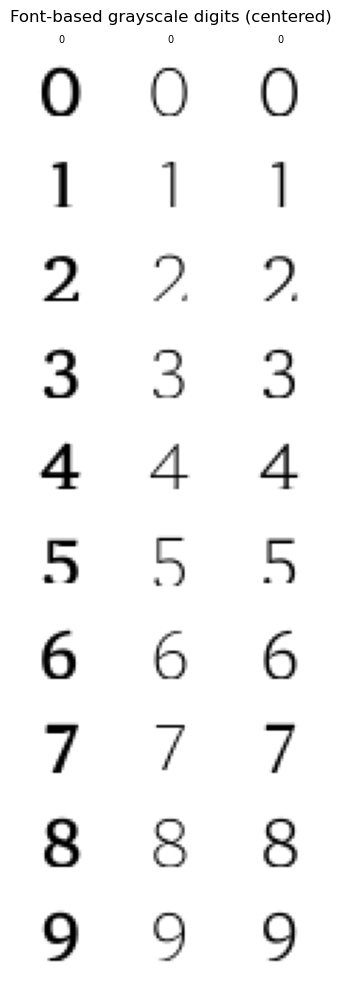

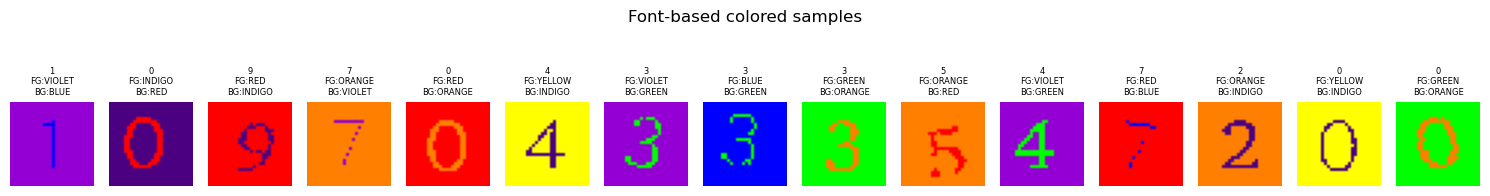

In [24]:
# -----------------------------
# [Cell 10] EDA-3/4: visualize font digits
# -----------------------------
if font_paths:
    def show_font_gray_samples(font_paths, n_per_digit=3):
        plt.figure(figsize=(n_per_digit * 1.2, 10))
        idx = 1
        for d in range(10):
            for font_path in font_paths[:min(3, len(font_paths))]:
                img = render_digit_with_font_centered(d, font_path)
                if img is None:
                    continue
                plt.subplot(10, n_per_digit, idx)
                plt.imshow(img, cmap="gray")
                plt.axis("off")
                if idx <= n_per_digit:
                    plt.title(str(d), fontsize=7)
                idx += 1
        plt.suptitle("Font-based grayscale digits (centered)", fontsize=12)
        plt.tight_layout()
        plt.show()

    show_font_gray_samples(font_paths, n_per_digit=3)

if isinstance(font_features, np.ndarray):
    def show_font_colored_samples(X, y_d, y_fg, y_bg, n=15):
        n = min(n, X.shape[0])
        idxs = np.random.choice(np.arange(X.shape[0]), size=n, replace=False)
        plt.figure(figsize=(n * 1.0, 2.5))
        for i, idx in enumerate(idxs):
            img = X[idx].reshape(28, 28, 3)
            d = y_d[idx]
            fg = COLOR_NAMES[y_fg[idx]]
            bg = COLOR_NAMES[y_bg[idx]]
            plt.subplot(1, n, i + 1)
            plt.imshow(img)
            plt.axis("off")
            plt.title(f"{d}\nFG:{fg}\nBG:{bg}", fontsize=6)
        plt.suptitle("Font-based colored samples", fontsize=12)
        plt.tight_layout()
        plt.show()

    show_font_colored_samples(font_features,
                              font_digit_labels,
                              font_fg_labels,
                              font_bg_labels,
                              n=15)

In [25]:
# -----------------------------
# [Cell 11] Merge all datasets (main + aug + font)
# -----------------------------
X_list = [base_main_features]
y_digit_list = [base_main_digit]
y_fg_list = [base_main_fg]
y_bg_list = [base_main_bg]

if isinstance(base_aug_features, np.ndarray):
    X_list.append(base_aug_features)
    y_digit_list.append(base_aug_digit)
    y_fg_list.append(base_aug_fg)
    y_bg_list.append(base_aug_bg)

if isinstance(font_features, np.ndarray):
    X_list.append(font_features)
    y_digit_list.append(font_digit_labels)
    y_fg_list.append(font_fg_labels)
    y_bg_list.append(font_bg_labels)

X_all = np.concatenate(X_list, axis=0)
y_digit_all = np.concatenate(y_digit_list, axis=0)
y_fg_all = np.concatenate(y_fg_list, axis=0)
y_bg_all = np.concatenate(y_bg_list, axis=0)

# shuffle
perm = np.random.permutation(X_all.shape[0])
X_all = X_all[perm]
y_digit_all = y_digit_all[perm]
y_fg_all = y_fg_all[perm]
y_bg_all = y_bg_all[perm]

print("[OK] Final merged dataset:")
print("  X_all      :", X_all.shape)
print("  y_digit_all:", y_digit_all.shape)
print("  y_fg_all   :", y_fg_all.shape)
print("  y_bg_all   :", y_bg_all.shape)


[OK] Final merged dataset:
  X_all      : (83867, 2352)
  y_digit_all: (83867,)
  y_fg_all   : (83867,)
  y_bg_all   : (83867,)



[EDA] Digit distribution:
digit
0    8304
1    9272
2    8301
3    8581
4    8147
5    7603
6    8340
7    8784
8    8282
9    8253
Name: count, dtype: int64

[EDA] FG index distribution:
fg
0    12044
1    11874
2    12149
3    11798
4    12122
5    11960
6    11920
Name: count, dtype: int64

[EDA] BG index distribution:
bg
0    11772
1    12005
2    11964
3    12033
4    11989
5    12097
6    12007
Name: count, dtype: int64

[EDA] (head) Digit x FG crosstab:
fg        0     1     2     3     4     5     6
digit                                          
0      1194  1143  1174  1158  1214  1194  1227
1      1339  1306  1344  1295  1310  1332  1346
2      1201  1174  1187  1193  1261  1120  1165
3      1237  1273  1255  1210  1187  1232  1187
4      1093  1137  1185  1186  1203  1193  1150


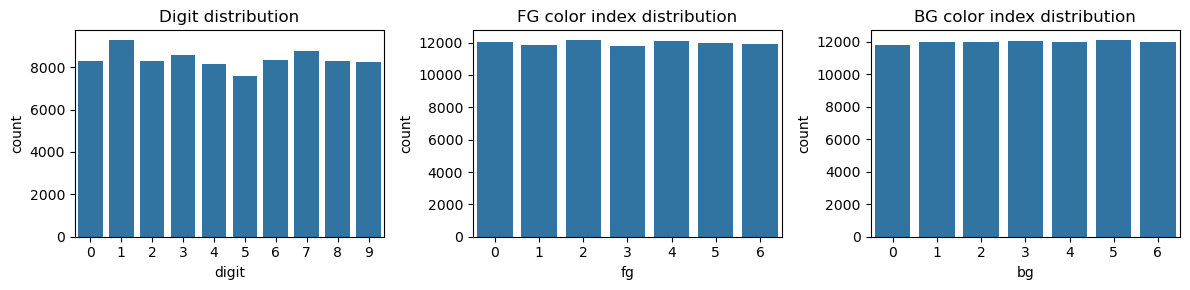

In [26]:
# -----------------------------
# [Cell 12] EDA-5: distributions
# -----------------------------
df_labels = pd.DataFrame({
    "digit": y_digit_all,
    "fg": y_fg_all,
    "bg": y_bg_all,
})

print("\n[EDA] Digit distribution:")
print(df_labels["digit"].value_counts().sort_index())

print("\n[EDA] FG index distribution:")
print(df_labels["fg"].value_counts().sort_index())

print("\n[EDA] BG index distribution:")
print(df_labels["bg"].value_counts().sort_index())

print("\n[EDA] (head) Digit x FG crosstab:")
print(pd.crosstab(df_labels["digit"], df_labels["fg"]).head())

plt.figure(figsize=(12, 3))
plt.subplot(1, 3, 1)
sns.countplot(x="digit", data=df_labels)
plt.title("Digit distribution")

plt.subplot(1, 3, 2)
sns.countplot(x="fg", data=df_labels)
plt.title("FG color index distribution")

plt.subplot(1, 3, 3)
sns.countplot(x="bg", data=df_labels)
plt.title("BG color index distribution")

plt.tight_layout()
plt.show()

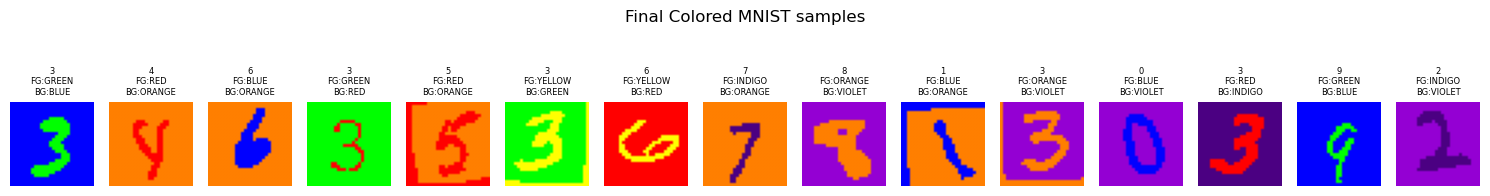

In [27]:
# -----------------------------
# [Cell 13] EDA-6: visualize final colored samples
# -----------------------------
def visualize_final_samples(X, y_d, y_fg, y_bg, n=15):
    n = min(n, X.shape[0])
    idxs = np.random.choice(np.arange(X.shape[0]), size=n, replace=False)
    plt.figure(figsize=(n * 1.0, 2.5))
    for i, idx in enumerate(idxs):
        img = X[idx].reshape(28, 28, 3)
        d = y_d[idx]
        fg = COLOR_NAMES[y_fg[idx]]
        bg = COLOR_NAMES[y_bg[idx]]
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"{d}\nFG:{fg}\nBG:{bg}", fontsize=6)
    plt.suptitle("Final Colored MNIST samples", fontsize=12)
    plt.tight_layout()
    plt.show()

visualize_final_samples(X_all, y_digit_all, y_fg_all, y_bg_all, n=15)

In [28]:
# -----------------------------
# [Cell 14] Train/Test split + standardization
# -----------------------------
X_train, X_test, \
y_digit_train, y_digit_test, \
y_fg_train, y_fg_test, \
y_bg_train, y_bg_test = train_test_split(
    X_all,
    y_digit_all,
    y_fg_all,
    y_bg_all,
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=y_digit_all,
)

print("\n[OK] Train/Test split:")
print("  X_train:", X_train.shape, "X_test:", X_test.shape)

mean = X_train.mean(axis=0)
std = X_train.std(axis=0) + 1e-8

X_train_std = (X_train - mean) / std
X_test_std = (X_test - mean) / std

print("[OK] Standardization done.")



[OK] Train/Test split:
  X_train: (67093, 2352) X_test: (16774, 2352)
[OK] Standardization done.


In [29]:
# -----------------------------
# [Cell 15] Save npz
# -----------------------------
out_path = os.path.join(PROCESSED_DIR, "colored_mnist.npz")

np.savez_compressed(
    out_path,
    X_train=X_train_std,
    X_test=X_test_std,
    X_train_raw=X_train,
    X_test_raw=X_test,
    y_digit_train=y_digit_train,
    y_digit_test=y_digit_test,
    y_fg_train=y_fg_train,
    y_fg_test=y_fg_test,
    y_bg_train=y_bg_train,
    y_bg_test=y_bg_test,
    mean=mean,
    std=std,
)

print(f"\n[OK] Saved: {out_path}")
print("\n[Sample labels]")
for i in range(5):
    print(
        f"idx {i}: digit={y_digit_train[i]}, "
        f"fg={y_fg_train[i]}({COLOR_NAMES[y_fg_train[i]]}), "
        f"bg={y_bg_train[i]}({COLOR_NAMES[y_bg_train[i]]})"
    )

print("\n✅ Preprocessing + EDA + augmentation completed.")


[OK] Saved: /Users/jaehun_jung/colored-mnist-classification/notebooks/data/processed/colored_mnist/colored_mnist.npz

[Sample labels]
idx 0: digit=6, fg=0(RED), bg=4(BLUE)
idx 1: digit=9, fg=0(RED), bg=3(GREEN)
idx 2: digit=9, fg=2(YELLOW), bg=0(RED)
idx 3: digit=6, fg=0(RED), bg=2(YELLOW)
idx 4: digit=8, fg=6(VIOLET), bg=2(YELLOW)

✅ Preprocessing + EDA + augmentation completed.
